In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = 'flow_cytometry_summary.csv'
df = pd.read_csv(data)

df.rename(columns={
    'Comp-Pacific Blue-A subset': 'cell viability',
    'After Mean': 'Knockdown'
}, inplace=True)

# get rid of the controls ( will look at later)
controls = df[(df['PEI Ratio'] == 0) & (df['NP Ratio'] == 0) & (df['PBA Ratio'] == 0)]
controls.reset_index(drop=True, inplace=True)
df = df[~((df['PEI Ratio'] == 0) & (df['NP Ratio'] == 0) & (df['PBA Ratio'] == 0))]
df.reset_index(drop=True, inplace=True)

X = df[['cell viability', 'Knockdown']].values 
y = df[['PEI Ratio', 'NP Ratio', 'PBA Ratio']].values

# Scale inputs and outputs
input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_scaled = input_scaler.fit_transform(X)
y_scaled = output_scaler.fit_transform(y)

# convert into tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# make the neual net class
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

# Initialize the model with updated input size
model = Net(input_size=2, output_size=3) # put in the cell viability and knockdown

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# grid for prediction using cell viability and Knockdown
cell_viability_values = np.linspace(df['cell viability'].min(), df['cell viability'].max(), num=50)
knockdown_values = np.linspace(df['Knockdown'].min(), df['Knockdown'].max(), num=50)

grid = np.meshgrid(cell_viability_values, knockdown_values)
grid_reshaped = np.stack([grid[0].ravel(), grid[1].ravel()], axis=1)

# scale grid inputs
grid_scaled = input_scaler.transform(grid_reshaped)
grid_tensor = torch.tensor(grid_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad(): #gradiants are not needed
    predictions_scaled = model(grid_tensor)
    predictions = output_scaler.inverse_transform(predictions_scaled.numpy())

# create results dataframe
results = pd.DataFrame(grid_reshaped, columns=['cell viability', 'Knockdown'])
results[['PEI Ratio', 'NP Ratio', 'PBA Ratio']] = predictions

# compute score 
results['Score'] = results['cell viability'] - results['Knockdown']

# Get top 5 results based on score
top_results = results.sort_values('Score', ascending=False).head(5)

# Display top results
print("\nTop 5 Ratios Predicted to Achieve Desired Outputs:")
print(top_results[['PEI Ratio', 'NP Ratio', 'PBA Ratio', 'Score']])

# Save results to CSV
results.to_csv('optimal_ratios.csv', index=False)


Epoch [100/500], Loss: 0.7705
Epoch [200/500], Loss: 0.8159
Epoch [300/500], Loss: 0.7448
Epoch [400/500], Loss: 0.7459
Epoch [500/500], Loss: 0.7284

Top 5 Ratios Predicted to Achieve Desired Outputs:
    PEI Ratio  NP Ratio  PBA Ratio      Score
49  57.087555  6.630209  20.361586  93.830000
48  56.727470  6.693657  20.525311  92.752449
99  58.358097  6.305332  19.701433  91.994694
47  56.392097  6.753204  20.666777  91.674898
98  57.956264  6.396869  19.858566  90.917143


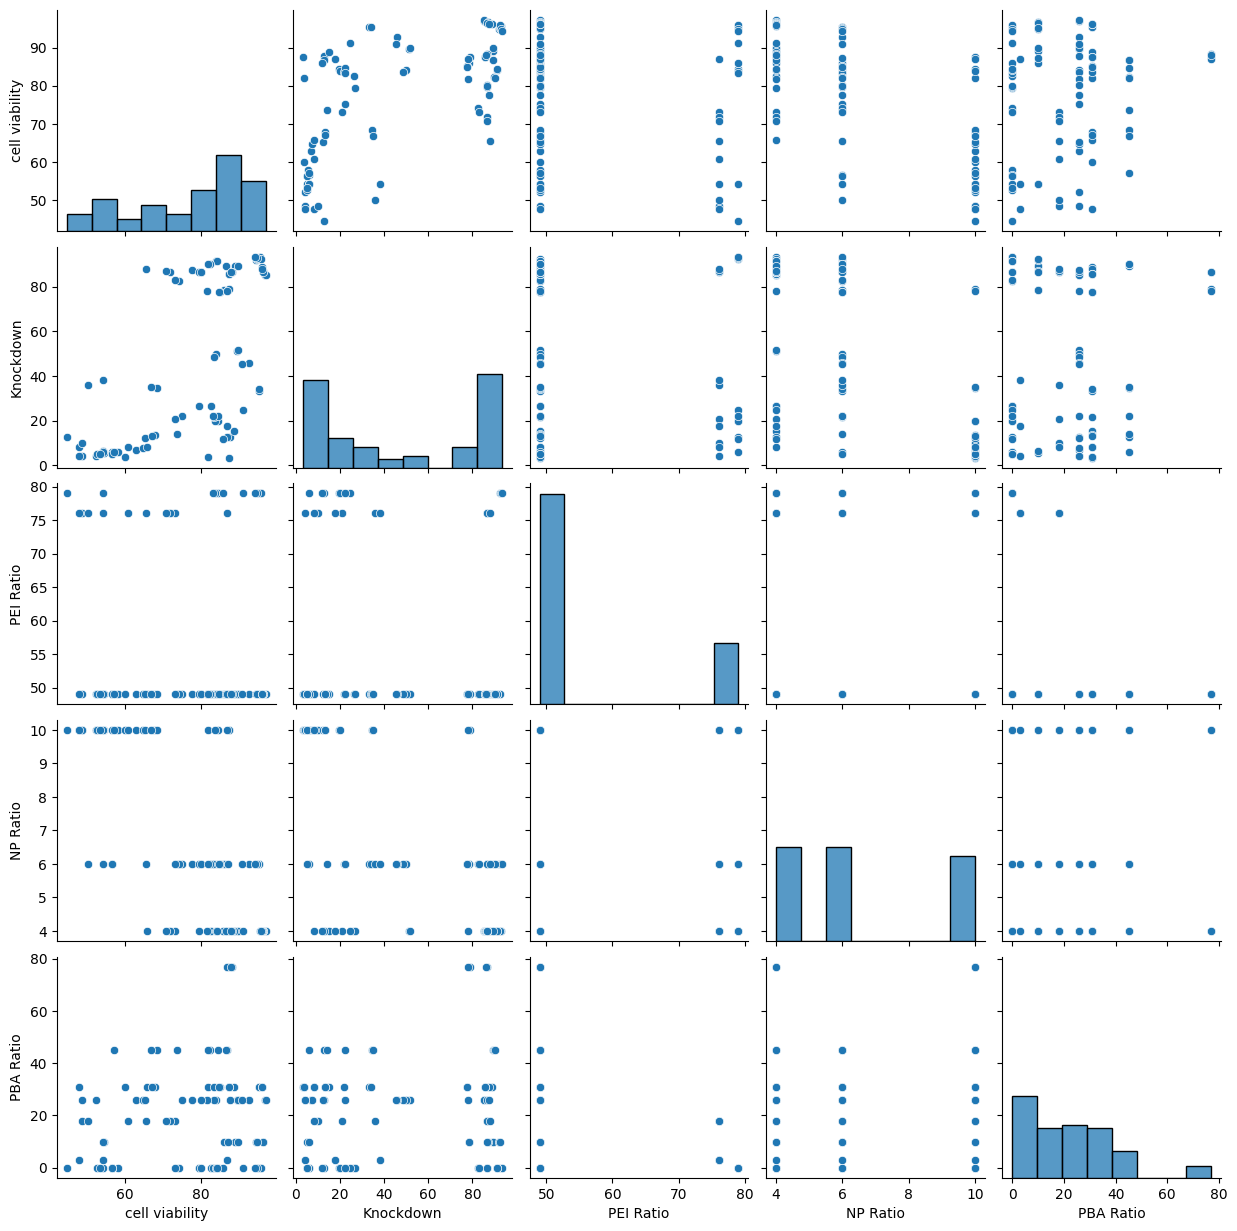

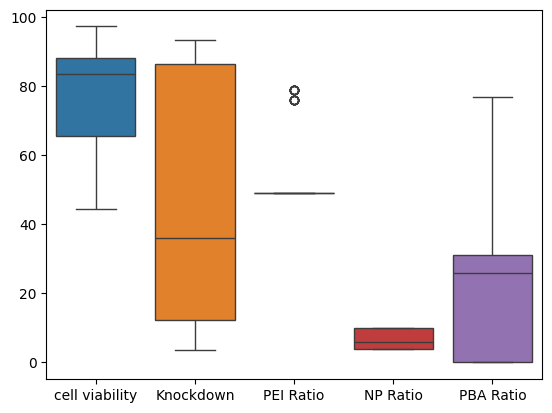

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize input features
sns.pairplot(df[['cell viability', 'Knockdown', 'PEI Ratio', 'NP Ratio', 'PBA Ratio']])
plt.show()

# Check for outliers
sns.boxplot(data=df[['cell viability', 'Knockdown', 'PEI Ratio', 'NP Ratio', 'PBA Ratio']])
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

best_val_loss = np.inf
patience = 20
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

model.load_state_dict(torch.load('best_model.pth'))


Early stopping at epoch 21


<All keys matched successfully>

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
